In [1]:
from datetime import date
import pandas as pd
import numpy as np
from pynytimes import NYTAPI
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# *Data mining*

In [2]:
API_df=pd.read_csv('API_df.csv')
API_key = API_df['Api key'][0] #Your API/Consumer key 
API_secret =API_df['Api secret key'][0]  #Your API/Consumer Secret Key

nyt = NYTAPI(API_key, parse_dates=True)

##### In the following blocks of code, we called the API and extracted the maximum article headers and their dates within the date range of Sep. 7th to Jan. 1st. 
 since the Call process is heavy, we exported the final CSV for more comfertable further usage.

In [ ]:
# Import datetime function from datetime library which allows us to create a datetime object

from datetime import datetime

#Set up start and end date objects

begin = datetime(2023, 9, 7)

end = datetime(2024, 1,7)

#Create dictionary containing dates data

date_dict = {"begin":begin, "end":end}

# Create options dictionary, Sort from earliest to latest, and Return only articles from New York Times, filters out other sources such as AP and Reuters

options_dict = {"sort": "oldest",
                "sources": ["New York Times"],
                "type_of_material": ["News Analysis", "News", "Article"],
               "body":["Gaza","Hamas","Israel"],
               "fq": 'headline:("Israel")'} 
               
# Final API call + Quary:

IL_data = nyt.article_search(

    query = "Israel",
    
    results=3000,

    dates =date_dict,

    options = options_dict)


C:\Users\97252\anaconda3\lib\site-packages\pynytimes\helpers\article_search.py:16: UserWarning: Asking for a lot of results, because of rate limits it can take a while.
  warnings.warn(
C:\Users\97252\anaconda3\lib\site-packages\pynytimes\helpers\article_search.py:23: UserWarning: Asking for more results then the API can provide,loading maximum results.
  warnings.warn(


In [ ]:
# Initialize a Pandas DataFrame to store New York Times data
nyt_data=pd.DataFrame(columns=['headline','date'])
headl=[]
datel=[]
for article in range(0,len(IL_data)):
    headline=IL_data[article]['headline']['main']
    date=IL_data[article]['pub_date'].date()
    headl.append(headline)
    datel.append(date)
    
# Initialize a Pandas DataFrame to store New York Times data
nyt_data['headline']=headl
nyt_data['date']=datel

# Export the DataFrame to a CSV file
nyt_data.to_csv('nyt_data.csv', index=False) 

In [3]:
nyt_data= pd.read_csv('nyt_data.csv')
nyt_data

,headline,date
0,‘Wounds Will Need to Be Healed’: Collisions in...,2023-09-11
1,"Israelis Have Been Protesting for Months. Now,...",2023-09-11
2,Israel’s Supreme Court Weighs Law That Limits ...,2023-09-12
3,An Israeli TV Channel for Netanyahu Fans Rapid...,2023-09-13
4,Biden Administration Says Israelis Can Travel ...,2023-09-27
...,...,...
610,"In Frothy Awards Season, What Role Will Israel...",2024-01-06
611,Hezbollah Fires Rockets at Israel in Response ...,2024-01-06
612,"American Unions Long Backed Israel. Now, Some ...",2024-01-07
613,"War Brings Tensions, and Assault Rifles, Into ...",2024-01-07


# *Tokenization and stop-words removal*
***

In [4]:
from nltk.tokenize import word_tokenize # Import tokenizer
from nltk.tokenize import word_tokenize
import string

# List to store word tokenized headlines
wt=[]

for item in nyt_data['headline']:
    # Removing punctuation and converting to lowercase
    headline_no_punctuation = re.sub(r'[^\w\s]', '', item).lower()
    # Tokenize the sentence
    wt.append(word_tokenize(headline_no_punctuation))
    
# Assign the word tokenized headlines to a new column in nyt_data
nyt_data['word_tokenized']=wt

### Removing stopwords and using lemmatization to normalize words

Lemmatization alone will be used in order to retain the word's semantics.

In [5]:
from nltk.corpus import stopwords
cleaned_text=[]
# nltk.download('stopwords') # download stopwords file
stop_words = set(stopwords.words('english')) # Set language as English and retrieve stopwords
stopwords = {'israel','israeli','Israeli','israelhamas','hamas','gaza','U','u'} # Define additional stopwords to exclude

stop_words.update(stopwords)

# Initialize a WordNet lemmatizer
lemma = nltk.stem.WordNetLemmatizer()

for record in nyt_data['word_tokenized']:
    # Lemmatize the tokenized words and retun a lemmatized list
    lemmas = [lemma.lemmatize(word) for word in record]
    # Remove stop words from the lemmatized list
    cleaned_text.append([word for word in lemmas if word not in stop_words])

nyt_data['cleaned_text']=cleaned_text

## *Visual Analysis of the amount of Research Items Published Along the Timeline*
---

On the other hand, 

It is visible that the NYT has shown an icreasing interest in the Middle East crisis since Oct 7 and for the duration of about a month, afterward there was a moderate decrease in the amount of articles written by the NYT concerning Israel.

<ipython-input-6-2d97649f782d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amount_data['date'] = pd.to_datetime(amount_data['date'])


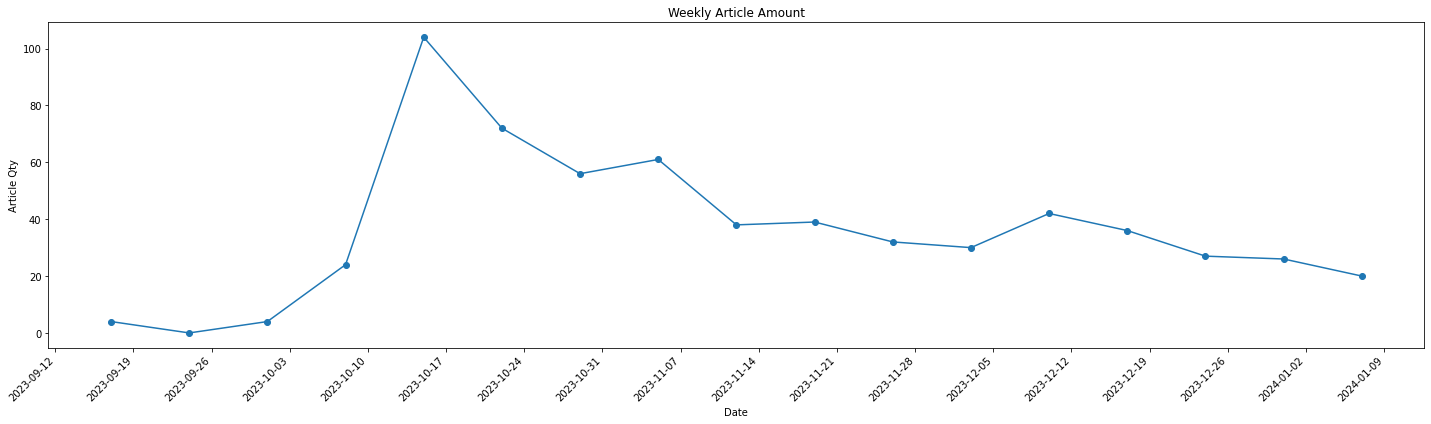

In [6]:
# Creating a joined text from all sentences in the "cleaned text" column
nyt_data['joined_clean']=nyt_data['cleaned_text'].apply(lambda words: ' '.join(words))
clean_text = '\n'.join(nyt_data['joined_clean'])

amount_data=nyt_data[['joined_clean','date']]
# Convert the date column to datetime type
amount_data['date'] = pd.to_datetime(amount_data['date'])

# Set the date column as the index
amount_data.set_index('date', inplace=True)

# Resample the DataFrame to group data by week and calculate the mean polarity score for each week
weekly_article_count = amount_data.resample('W').size()

# Plot the line plot for the weekly article quantity
plt.figure(figsize=(20, 6))
plt.plot(weekly_article_count.index, weekly_article_count, marker='o', linestyle='-')
plt.title('Weekly Article Amount')
plt.xlabel('Date')
plt.ylabel('Article Qty')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())  # Set major ticks to display weeks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
plt.tight_layout()
plt.show()

# *Sentiment analysis*
---
### WordCloud

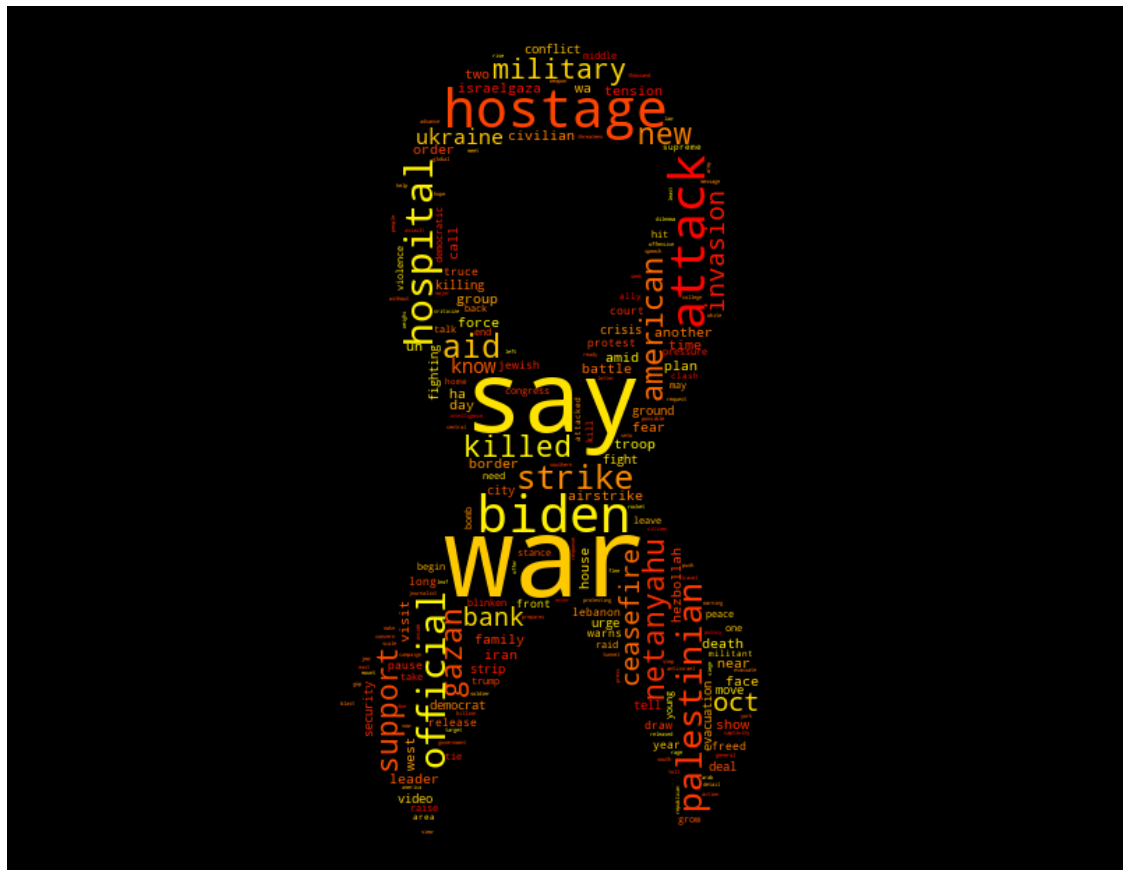

In [7]:
from wordcloud import WordCloud,STOPWORDS
from PIL import Image
import seaborn as sns

# Wordcloud:
# Inserting a shape mask for the wordcloud design
img_mask = np.array(Image.open('./Yellow_Ribbon.png'))

wc=WordCloud(
    background_color='black',
    collocations=False,  # Ensure each word is presented only once
    mask= img_mask,contour_width=1,
        colormap = 'autumn',
    random_state = 1,
    width = 800,
    height = 500).generate(clean_text)

plt.figure(figsize=[20,20])
plt.tight_layout()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()





### You can see that the larger the word,the more frequent it is.

During our analysis we found that there was an anomaly in the Wordcloud. A "U" word appeared very often, therefore we took it out using the stopwords list. 

# *Comparing the sentiment score between the raw sentence and the cleaned one*
--
almost no change

In [8]:
# Use the SentimentIntensityAnalyzer to compute the sentiment scores
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Polarity on raw data
polarity_score=[]
for i in range(len(nyt_data['headline'])):
    sentiment = SentimentIntensityAnalyzer().polarity_scores(nyt_data['headline'][i])
    polarity_score.append(sentiment['compound'])
nyt_data['polarity_score_raw']=polarity_score

# Polarity on cleaned data
polarity_score_clean=[]
for i in range(len(nyt_data['joined_clean'])):
    sentiment_c = SentimentIntensityAnalyzer().polarity_scores(nyt_data['joined_clean'][i])
    polarity_score_clean.append(sentiment_c['compound'])
    
nyt_data['polarity_score_clean']=polarity_score_clean
# Compute average polarity scores for raw and cleaned data grouped by date
average_polarity_scores_raw = nyt_data.groupby('date')['polarity_score_raw'].mean()
average_polarity_scores_clean = nyt_data.groupby('date')['polarity_score_clean'].mean()


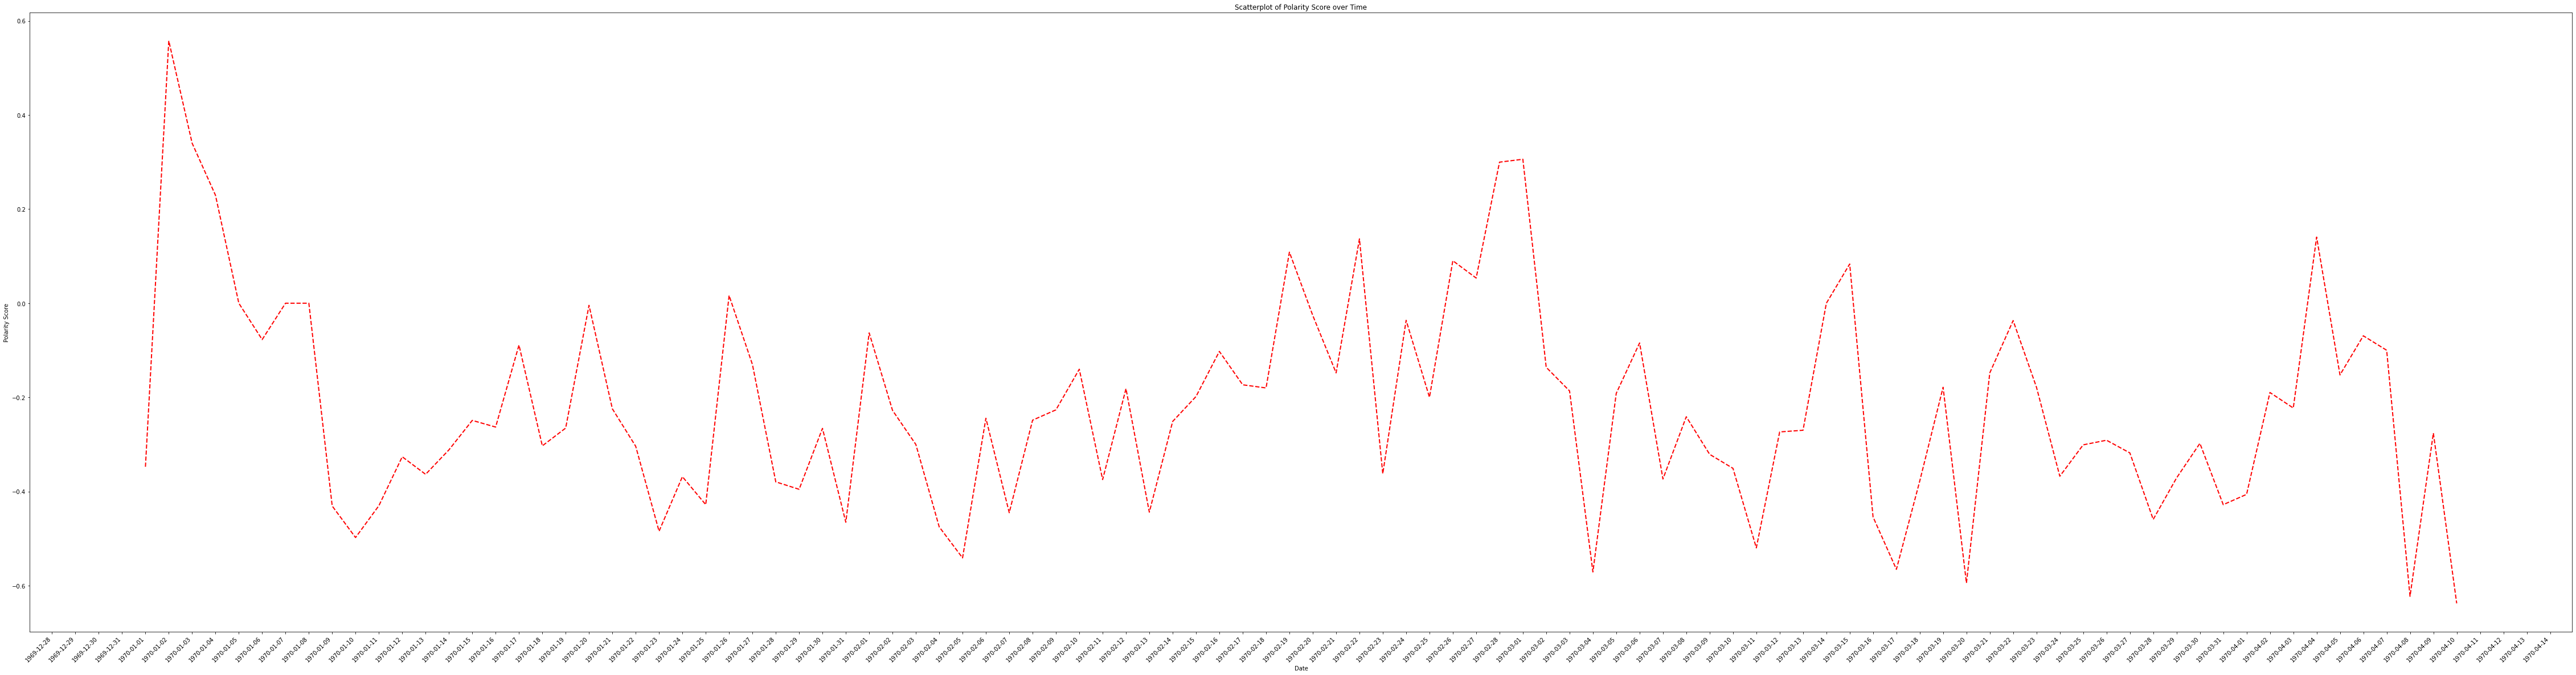

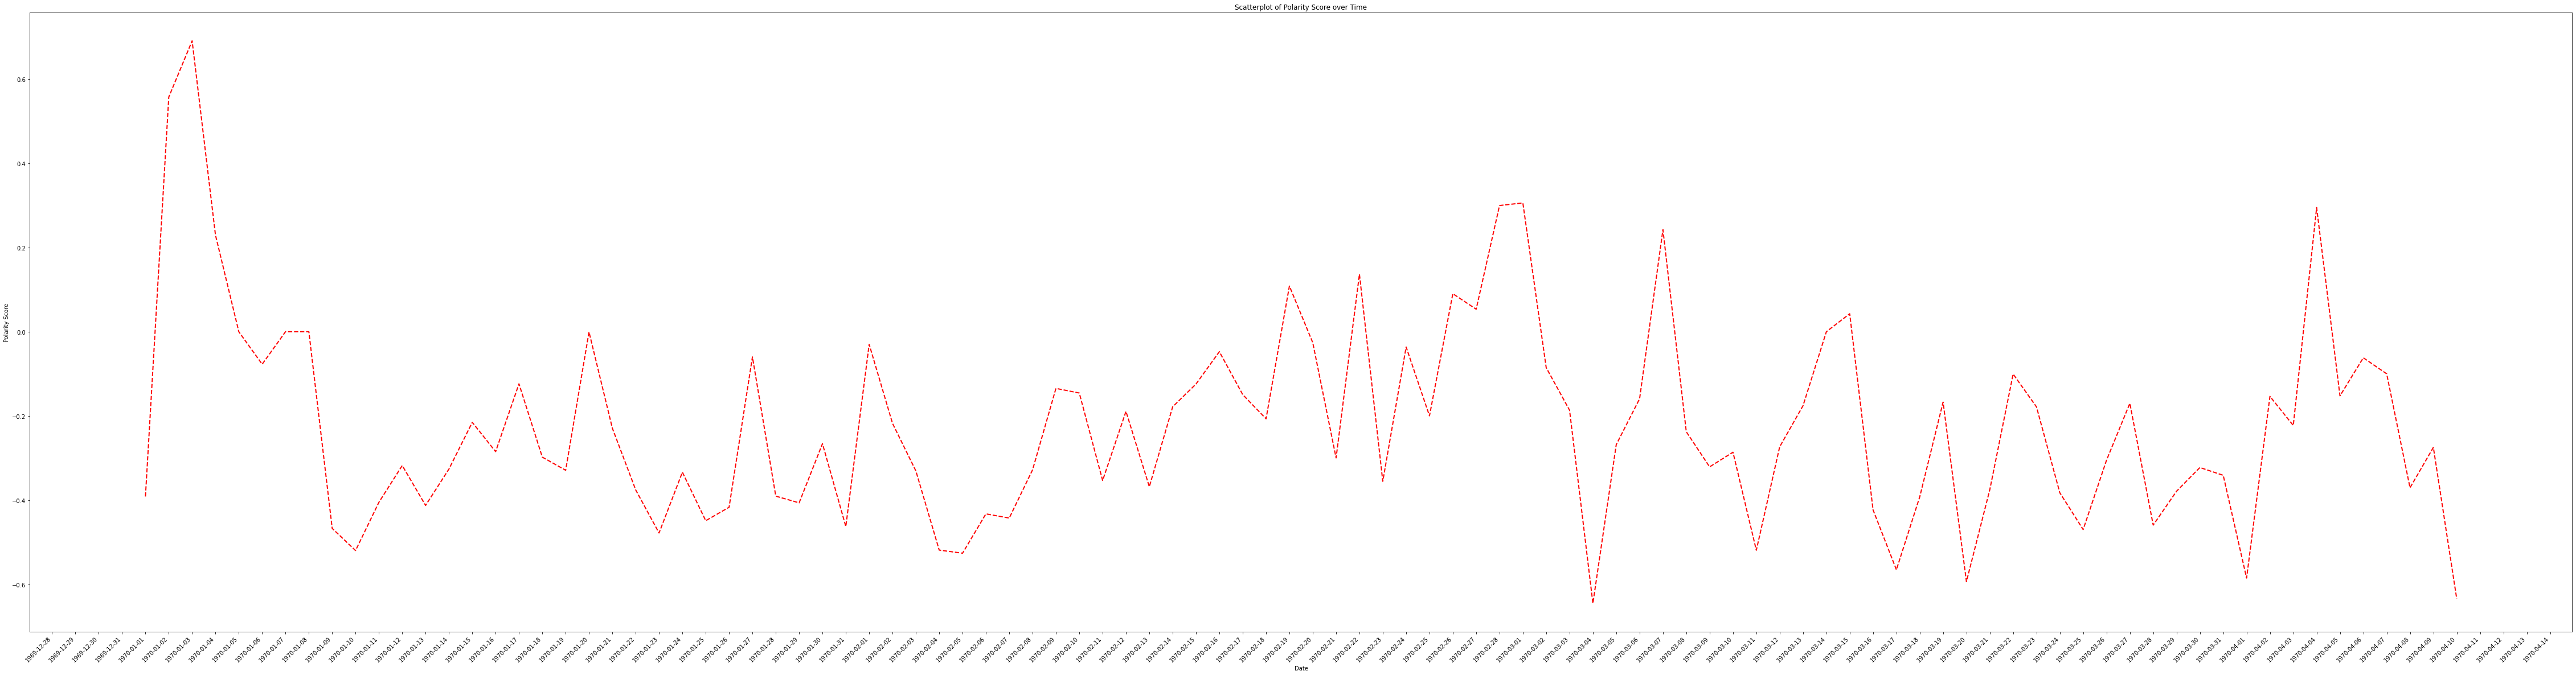

In [9]:
import seaborn as sns
import matplotlib.dates as mdates
nyt_data['date'] = pd.to_datetime(nyt_data['date'])

def plot_polarity(polarity, avg_polarity):
    plt.figure(figsize=(80, 20))
    sns.scatterplot(data=nyt_data, x='date', y=polarity, alpha=0.5, s=50, color='blue')  
    plt.plot(avg_polarity.index, avg_polarity.values, color='red', linestyle='--', linewidth=2)
    plt.xticks(rotation=45, ha='right')
    plt.gca().xaxis.set_major_locator(mdates.DayLocator()) 
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.title('Scatterplot of Polarity Score over Time')
    plt.xlabel('Date')
    plt.ylabel('Polarity Score')
    plt.show()

plot_polarity('polarity_score_raw', average_polarity_scores_raw)
plot_polarity('polarity_score_clean', average_polarity_scores_clean)

## *The positive avg polarity score days*
---

***Aanalysies of the days where the average positive polarity score is at his highest***

In [10]:
pd.set_option('display.max_colwidth', None)
# Get the dates where the average polarity score is greater than 0.1
dates_above_threshold = average_polarity_scores_clean[average_polarity_scores_clean > 0.1].index

# Filter the nyt_data DataFrame based on the dates and before October 7th
filtered_data = nyt_data[(nyt_data['date'].isin(dates_above_threshold)) & (nyt_data['date'] > '2023-10-07')]

# Now filtered_data contains the rows where average_polarity_scores_clean > 0 and the date is before October 7th
# You can access the 'joined_clean' column of the filtered data
filtered_joined_clean = filtered_data[['headline','date','polarity_score_clean']]
filtered_joined_clean

,headline,date,polarity_score_clean
393,Israeli and Palestinian Activists Ask Americans to Take Side of Peace,2023-11-17,0.5423
394,"Israeli Army Escorts Journalists to Gaza Hospital, and More",2023-11-17,0.0000
395,Former Obama and Biden Officials Sign Letter Defending U.S.’s Israel Stance,2023-11-17,0.0000
396,Israel Displays Tunnel Shaft at Gaza Hospital and Says It Will Let In Some Fuel,2023-11-17,0.0000
397,Israel Says Hospital Held Hamas Command Center: How Long Could It Take for Proof?,2023-11-17,0.0000
402,"Between Israelis and Palestinians, a Lethal Psychological Chasm Grows",2023-11-20,0.0000
403,Israel and Hamas Agreed to a Cease-Fire and Hostage Release. Here’s What We Know.,2023-11-20,0.2732
432,"Freed Israeli Hostages Share Details of Captivity, Relatives Say",2023-11-26,0.5994
433,Prime Minister Netanyahu Visits Israeli Troops in Gaza,2023-11-26,0.0000
434,Elon Musk Visits Israel Amid Backlash Against His Endorsement of Antisemitic Post,2023-11-27,0.3182


### The events behind the most positive days during the timzone

2023-11-17:

[NYT](https://www.nytimes.com/2023/11/17/world/middleeast/israel-gaza-tunnel-hamas.html)

13 NEWS: IDF finds Hamas infrastructure in Al-Shifa Hospital and gathers more information about the hostages.
        More fuel entered Gaza from Egypt.
    
-----
2023-11-20: 

[NYT](https://www.nytimes.com/2023/11/20/world/middleeast/israel-hamas-hostage-negotiations.html)

            First agreement for ceasefire: two sides agree to a four-day ceasefire in exchange for the release of 50 hostages.
    
 ["Yoman Milchama (21.11)":](https://www.zman.co.il/440449/)
 
            Ceasefire is imminent; 50 hostages will be released in exchange for 4 days of ceasefire. (2023-11-24: First batch of hostage release)
    
-----
2023-11-26: 

[NYT](https://www.nytimes.com/2023/11/26/world/middleeast/freed-israeli-hostages-captivity.html)

            Two days after the first batch of hostages was released, relatives of the family talk to the press.
            
["Yoman Milchama (26.11)":](https://www.zman.co.il/441925/popup/)
             Another hostage list published with 14 names; Hamas asks to extend the ceasefire.
-----        
2023-11-27: 

[NYT](https://www.nytimes.com/2023/11/27/world/middleeast/israel-gaza-hamas-hostages.html)

            Hamas and Israel agree to extend ceasefire for 2 days; Elon Musk visits Israel amid backlash against his endorsement of antisemitic post.
            
["Yoman Milchama (27.11)":](https://www.zman.co.il/442326/popup/)
             The extension is approved from both sides in exchange for 20 hostages.
-----
2023-12-03: 

[NYT](https://www.nytimes.com/2023/12/03/world/middleeast/israel-war-mothers.html)

            Positive compassion from the Times, although not a positive subject.
            Article about the Mothers of the soldiers serving in Gaza Strip; U.S. pressing on resuming talks for truce.
            
 ["Yoman Milchama (3.12)":](https://www.zman.co.il/444293/)

            IDF started fighting in the southern district; the war in the north is deteriorating.
            
-----
2024-01-01: 

[NYT](https://www.nytimes.com/2024/01/01/world/middleeast/israel-supreme-court-justices-ruling.html)

            Israel's supreme court struck down the Amendment of the Reasonableness Law.
           
[Yoman Milchama (1.1.24)](https://www.zman.co.il/452748/popup/)

            Israel will appear at the Hague Tribunal in an attempt to prevent decisions that would stop its activities in the Gaza Strip; in addition, Israel's supreme court struck down the Amendment of the Reasonableness Law.


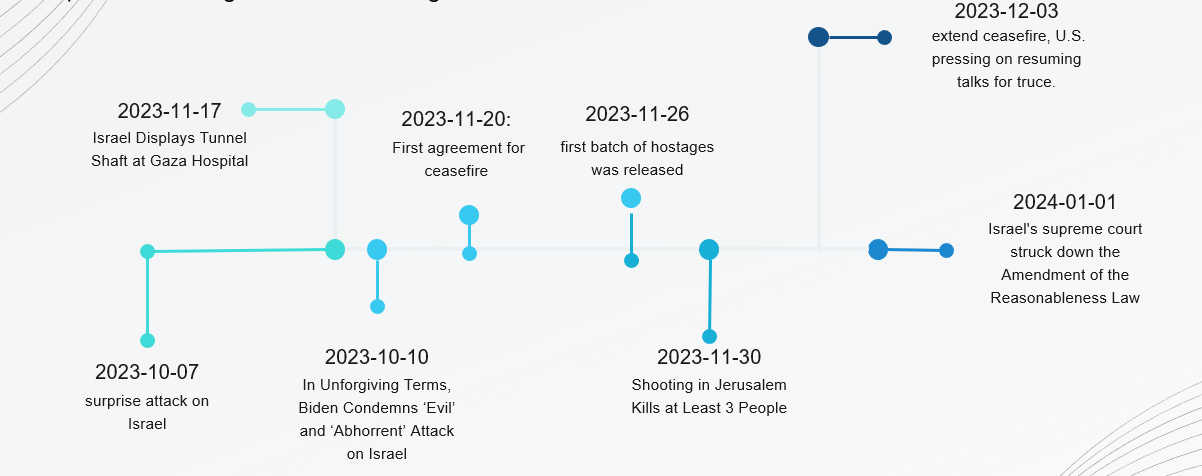

## *The negative avg polarity score days*
---

***Analysies of the days where the average negative polarity score is at his highest***

In [11]:
pd.set_option('display.max_colwidth', None)
# Get the dates where the average polarity score is the smallest
dates_above_threshold = average_polarity_scores_clean[average_polarity_scores_clean==min(average_polarity_scores_clean) ].index

# Filter the nyt_data DataFrame based on the dates or articles from  October 7th
filtered_data = nyt_data[(nyt_data['date'].isin(dates_above_threshold)) | (nyt_data['date'] == '2023-10-07')]

# Now filtered_data contains the rows where average_polarity_scores_clean > 0 and the date is before October 7th
# You can access the 'joined_clean' column of the filtered data
filtered_joined_clean = filtered_data[['headline','date','polarity_score_clean']]
filtered_joined_clean

,headline,date,polarity_score_clean
10,Here is what to know about the surprise attack on Israel.,2023-10-07,-0.2500
11,The war could upend Biden’s diplomacy on Saudi-Israel normalization.,2023-10-07,-0.5994
12,An Attack From Gaza and an Israeli Declaration of War. Now What?,2023-10-07,-0.7906
13,Israel’s Military Says Hamas Has Taken Hostages,2023-10-07,0.3400
14,‘The Children Were Terrified.’ Fear Grips Israel and Gaza,2023-10-07,-0.8020
15,Israel’s defense failures may change strategy toward Hamas and Gaza.,2023-10-07,-0.4215
16,G.O.P. Candidates Use Attacks on Israel to Criticize Biden for His Iran Deal,2023-10-07,-0.6908
17,Graphic Images of Violence Flood Social Media Amid Israel-Gaza Conflict,2023-10-07,-0.7506
18,Here is a timeline of the clashes between Palestinian militants and Israel.,2023-10-07,0.0000
19,"‘We Are at War,’ Netanyahu Says After Hamas Attacks Israel",2023-10-07,-0.7906


Surprisingly, we got that the most negative score was received on 11/30 and not on October 7th. the reasons for that are:

1. One of the articles in October 7 received a positive score, although the article is talking about hostages.
2. On November 30 there is not a single positive nor neutral article, therefore the avarage polarity score is the most negative one.

In addition, we filtered in the articles written on October 7, to see their scores.

Now we will examine the minimal absolute score, to avoid such bias:

In [12]:
# Retrieve the record corresponding to the minimum polarity score clean
min_result=nyt_data.loc[nyt_data['polarity_score_clean']==min(nyt_data['polarity_score_clean'])]['date']
nyt_data[(nyt_data['date'].isin(min_result))][['headline','date','polarity_score_clean']].sort_values(by='polarity_score_clean')

,headline,date,polarity_score_clean
60,"In Unforgiving Terms, Biden Condemns ‘Evil’ and ‘Abhorrent’ Attack on Israel",2023-10-10,-0.9423
49,Fragile Global Economy Faces New Crisis in Israel-Gaza War,2023-10-10,-0.8402
52,"Israel Orders Gaza ‘Siege,’ Hamas Threatens to Kill Hostages, and More",2023-10-10,-0.8074
66,Hamas Seeds Violent Videos on Sites With Little Moderation,2023-10-10,-0.5994
56,The Israel-Hamas War: A Forum for Young People to React,2023-10-10,-0.5994
69,Hamas Leaves Trail of Terror in Israel,2023-10-10,-0.5267
50,Peace Activists Are Among the Israelis Missing and Killed,2023-10-10,-0.4939
68,"Along Israel’s Borders With Lebanon and Syria, Clashes Raise Fears of Another Front",2023-10-10,-0.4939
64,"After Attack on Israel, Politicians Are Asked, ‘Which Side Are You On?’",2023-10-10,-0.4767
48,Late Night Hosts Address the Hamas Attacks on Israel,2023-10-10,-0.4767


the most negative article is the one found on October 10, 

[In Unforgiving Terms, Biden Condemns ‘Evil’ and ‘Abhorrent’ Attack on Israel](https://www.nytimes.com/2023/10/10/us/politics/biden-israel-hamas.html)

Up until now,the sentiment analsis has shown that despite the very negative image drawn from the polarity score along the timeline,

when coming to investigate each "extreme" article it is clear that there is no visible political side taken by the NYT.

The sentiment analysis conceiders some words more negative and does not takes in account the context of the sentence.

Hence, we cannot claim that the NYT are more Pro-Israel nor Pro-Hmas.


# *topic analysis*
---
##### in this section we will create a corpus from a dictionary of all the cleaned words from the data, to see the main topics discussed in the timeframe of the war

In [13]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel, LsiModel, HdpModel

# Create Dictionary
dictionary = Dictionary(nyt_data['cleaned_text'])
# Create Corpus
corpus = [dictionary.doc2bow(text) for text in nyt_data['cleaned_text']]



In [14]:
# Number of topics
num_topics = 3

np.random.seed(4)
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)


# Print the Keyword in the 5 topics

doc_lda = lda_model[corpus]
lda_model.show_topics()

[(0,
  '0.018*"war" + 0.012*"biden" + 0.012*"say" + 0.011*"hostage" + 0.010*"hospital" + 0.009*"attack" + 0.008*"aid" + 0.006*"ukraine" + 0.005*"official" + 0.005*"bidens"'),
 (1,
  '0.014*"hostage" + 0.010*"war" + 0.010*"say" + 0.007*"attack" + 0.006*"support" + 0.005*"military" + 0.004*"ceasefire" + 0.004*"american" + 0.004*"long" + 0.004*"ha"'),
 (2,
  '0.026*"war" + 0.019*"say" + 0.010*"attack" + 0.008*"palestinian" + 0.008*"hostage" + 0.007*"official" + 0.006*"strike" + 0.006*"bank" + 0.006*"american" + 0.006*"killed"')]

In [15]:
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

C:\Users\meita\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.066848 -0.032921       1        1  40.326946
2     -0.065567 -0.034889       2        1  35.459618
1     -0.001281  0.067810       3        1  24.213435, topic_info=          Term       Freq      Total Category  logprob  loglift
249        aid  15.000000  15.000000  Default  30.0000  30.0000
163    ukraine  10.000000  10.000000  Default  29.0000  29.0000
52        west   9.000000   9.000000  Default  28.0000  28.0000
86        iran   7.000000   7.000000  Default  27.0000  27.0000
47        bank  10.000000  10.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
310     family   2.484135   8.984294   Topic3  -5.8819   0.1327
9        court   2.161072   5.559836   Topic3  -6.0213   0.4733
545  hezbollah   2.249656   7.528825   Topic3  -5.9811   0.2103
30    official   2.462687  19.010044   Topic3  -5.8906  -0.6255
23       biden   2.473312  26.565525   Topic3  -5.8863  -0.9558

[220 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
682       1  0.924672     105
747       1  0.444315       7
747       2  0.444315       7
747       3  0.177726       7
713       2  0.959370    92ny
...     ...       ...     ...
52        2  0.772956    west
52        3  0.110422    west
1149      1  0.691932  worker
248       2  0.821056   young
490       2  0.719140    zone

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

### *Topic #1-* 

Represents the war. we can see that the most weighted words are "war","attack","oct 7", "strike" ,"killed" etc...

### *Topic #2-* 

ֳֳֳֳֳRepresents more political and aid semantics. leading words are "Biden", "aid" , "support", "say" "americans" etc..


### *Topic #3-* 

Represents a hostages view. leading words are "hotage", "hospital ," family","release","ceasefire" and "truce" etc..

In [16]:
pip freeze > requirements.txt

C:\Users\meita\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.
